## Introduction

This notebook demonstrates how to fine-tune a 4-bit quantized model (quantized using bitsandbytes) with the QLoRA technique, utilizing the Unsloth library. It is adapted from the official Unsloth fine-tuning notebook with the following modifications:
- LoRA configuration has been adjusted to exclude vision layers
- An evaluation script has been added to assess the fine-tuned mode

## Prepare Dataset 

In [1]:
from datasets import load_dataset
dataset,test_dataset = load_dataset("unsloth/LaTeX_OCR", split=['train[:80%]', 'test[:20%]'])

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }

In [7]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
converted_test_dataset = [convert_to_conversation(sample) for sample in test_dataset]

## Inference using Baseline Quantized Model

In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-20 23:18:19 [__init__.py:244] Automatically detected platform cuda.


2025-06-20 23:18:23,453	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.6.2: Fast Qwen2 patching. Transformers: 4.52.3. vLLM: 0.9.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.15 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [8]:
model = FastVisionModel.get_peft_model(
    model,
    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
)


INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          
Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [9]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# Run inference without streamer
generated_ids = model.generate(
    **inputs,
    max_new_tokens=256,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = tokenizer.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

["\\begin{align*} H' &= \\beta N \\int d\\lambda \\left\\{ \\frac{1}{2\\beta^2 N^2} \\partial_\\lambda \\zeta^\\dagger \\partial_\\lambda \\zeta + V(\\lambda) \\zeta^\\dagger \\right\\} \\end{align*}"]


## Train the model

In [10]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    eval_dataset = converted_test_dataset,  # Optional, but useful
    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 1,
        per_device_eval_batch_size = 4,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 3, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = False,
        bf16 = True,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases
        save_strategy="epoch",  # Strategy for saving the model
        eval_strategy="epoch",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [11]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.15 GB.
2.438 GB of memory reserved.


In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 54,949 | Num Epochs = 3 | Total steps = 20,607
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768/2,000,000,000 (0.92% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,0.068200,0.100811
2,0.028100,0.090811
3,0.023600,0.096599


Unsloth: Will smartly offload gradients to save VRAM!


## Test Finetuned model

In [2]:
# Import Libraries
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch

# Configure quantization settings 
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.float16
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    quantization_config=nf4_config,
    device_map="auto",
)
# Set up processor with optimal token ranges
min_pixels = 28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be remove

In [15]:
from IPython.display import display, Math, Latex

index = 25
latex = test_dataset[index]["text"]
latex

'( 5 . 1 7 ) = - \\frac { ( - i ) ^ { m + n - 1 } } { ( m + n - 1 ) ! } z ^ { m + n - 1 } \\left\\{ \\frac { 1 } { 4 } \\frac { 1 } { \\lambda } z ^ { 2 \\lambda } + \\frac { 1 } { 2 } \\ln ( z ) \\right\\}'

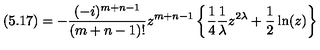

In [16]:
test_dataset[index]["image"]

In [17]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
   return [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]

converted_dataset = [convert_to_conversation(sample) for sample in dataset]
converted_test_dataset = [convert_to_conversation(sample) for sample in test_dataset]

In [18]:
instruction = "Write just the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text =  processor.apply_chat_template(messages, add_generation_prompt = True)
image_inputs, _ = process_vision_info(converted_test_dataset[index])
inputs = processor(
    text=[input_text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [7]:
adapter_path_epoch_1 = "/home/madhusudhanan.a/vlms/outputs/checkpoint-6869"
adapter_path_epoch_2 = "/home/madhusudhanan.a/vlms/outputs/checkpoint-13738"
adapter_path_epoch_3 = "/home/madhusudhanan.a/vlms/outputs/checkpoint-20607"
model.load_adapter(adapter_path_epoch_1,adapter_name="epoch_1")
model.load_adapter(adapter_path_epoch_2,adapter_name="epoch_2")
model.load_adapter(adapter_path_epoch_3,adapter_name="epoch_3")

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Let's run the inference using baseline quantized model. We will use `model.disable_adapters_adapters()` to disable lora adapters. Make sure to enable adapters back using `model.enable_adapters()`

In [13]:
model.disable_adapters() # Disable adapters
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128, use_cache=True,
    temperature=1.5,
    min_p=0.1)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

model.enable_adapters() # Enable adapters back

['\\begin{equation*}\nZ = \\frac{H}{N} + N^2 + H^2 = \\frac{24}{\\lambda \\kappa}\n\\end{equation*}', '\\[\n\\tilde{Z}_0^{-1} = \\int \\mathcal{D} \\varphi \\mathcal{D} \\varphi^* \\exp \\left\\{ \\frac{i}{m} \\int d^4 x \\varphi^* \\left( \\partial^\\mu \\partial_\\mu + m^2 \\right) \\varphi \\right\\}.\n\\]', '\\begin{align*}\n\\varphi(x^+, x^-, +I, x^1 + sI, x^2) = \\varphi(x^+, x^-, x^1, x^2),\n\\end{align*}', '(12,12),(987,987)', '(123,131),(877,937)', '\\begin{align*}\n\\left[ \\sigma_c \\sigma_c \\right] \\epsilon_c X^u = (a^u \\epsilon^u + a^c \\epsilon^c)\n\\end{align*}', '\\begin{equation*}\n\\operatorname{tr}(R \\cap \\dots \\cap R) = \\operatorname{tr}(R^k).\n\\end{equation*}', 'The LaTeX representation for the image is:\n\n```latex\nN = tr \\int d^3 x \\left( A_\\mu \\frac{\\delta}{\\delta A_\\mu} + c \\frac{\\delta}{\\delta c} + A_\\mu \\frac{\\delta}{\\delta A_\\mu^*} + c^* \\frac{\\delta}{\\delta c^*} \\right).\n```', '\\[\n\\frac{1}{\\sqrt{-\\eta \\eta^{\\mu \\nu}}} = 

As you can see, the baseline quantized model does not perform well in predicting the correct latex equation.

Now let's set the LoRA adapter from epoch 3 as the active adapter and run inference

In [19]:
model.set_adapter("epoch_3")  # Set the adapter to the last epoch

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128, use_cache=True,
    temperature=1.5,
    min_p=0.1)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

display(Math(output_text[0]))

['( 5 . 1 7 ) = - \\frac { ( - i ) ^ { m + n - 1 } } { ( m + n - 1 ) ! } z ^ { m + n - 1 } \\left\\{ \\frac { 1 } { 4 } \\frac { 1 } { \\lambda } z ^ { 2 } \\lambda ^ { 2 } + \\frac { 1 } { 2 } \\ln ( z ) \\right\\}']


<IPython.core.display.Math object>

The fine-tuned model performs well on the test sample !!

## Evaluate the model

Let's evaluate the model on test dataset to see how well our model performs on the test set. We will evaluate our model using the following Metric:
1. [Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
2. [Levenshtein edit distance](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0)

In [11]:
# Remove unnecessary whitespace from LaTeX code.
import re
def post_process(s: str):
    text_reg = r'(\\(operatorname|mathrm|text|mathbf)\s?\*? {.*?})'
    letter = '[a-zA-Z]'
    noletter = '[\W_^\d]'
    names = [x[0].replace(' ', '') for x in re.findall(text_reg, s)]
    s = re.sub(text_reg, lambda match: str(names.pop(0)), s)
    news = s
    while True:
        s = news
        news = re.sub(r'(?!\\ )(%s)\s+?(%s)' % (noletter, noletter), r'\1\2', s)
        news = re.sub(r'(?!\\ )(%s)\s+?(%s)' % (noletter, letter), r'\1\2', news)
        news = re.sub(r'(%s)\s+?(%s)' % (letter, noletter), r'\1\2', news)
        if news == s:
            break
    return s

In [ ]:
# To evaluate Baseline model, disable adapter first (Uncomment the line below)
# model.disable_adapters()

In [12]:
import evaluate
import Levenshtein
from tqdm import tqdm
import torch
from torch.nn import functional as F


# Initialize evaluation tools
bleu_metric = evaluate.load("bleu")

all_predictions = []
all_references = []
norm_edit_dists = []

instruction = "Write the LaTeX representation for this image."
batch_size = 64
n_samples = len(converted_test_dataset)

for start_idx in tqdm(range(0, n_samples, batch_size), desc="Evaluating"):
    batch = converted_test_dataset[start_idx : start_idx + batch_size]

    batch_texts = []
    batch_images = []
    batch_ground_truths = []

    for sample in batch:
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]}
        ]
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        batch_texts.append(input_text)

        image_inputs, _ = process_vision_info(sample)
        batch_images.append(image_inputs)

        gt = sample[1]['content'][0]['text']
        batch_ground_truths.append(gt)

    # Process batch
    inputs = processor(
        text=batch_texts,
        images=batch_images,
        padding=True,
        return_tensors="pt"
    ).to("cuda")

    # Inference
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=128)

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    batch_outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    for pred, true in zip(batch_outputs, batch_ground_truths):
        all_predictions.append(pred)
        all_references.append([true])  # wrap for BLEU

        norm_dist = Levenshtein.distance(post_process(pred), post_process(true)) / max(len(pred), len(true))
        norm_edit_dists.append(norm_dist)
    
# Final evaluation
bleu_result = bleu_metric.compute(predictions=all_predictions, references=all_references)
average_edit_distance = sum(norm_edit_dists) / len(norm_edit_dists)


# Print results
print("BLEU Score:", bleu_result['bleu'])
print("Average Normalized Edit Distance:", average_edit_distance)


Evaluating: 100%|██████████| 24/24 [04:50<00:00, 12.11s/it]


BLEU Score: 0.8194071094627821
Average Normalized Edit Distance: 0.09973906130739238


In [14]:
model.push_to_hub("arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_nf4_epoch3", token = "your_hf_token_here") # Online saving


adapter_model.safetensors: 100%|██████████| 73.9M/73.9M [00:01<00:00, 47.3MB/s]


CommitInfo(commit_url='https://huggingface.co/arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_nf4_epoch3/commit/dc9169094ab0106d63fe7ae244b9070e0488b4fe', commit_message='Upload Qwen2VLForConditionalGeneration', commit_description='', oid='dc9169094ab0106d63fe7ae244b9070e0488b4fe', pr_url=None, repo_url=RepoUrl('https://huggingface.co/arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_nf4_epoch3', endpoint='https://huggingface.co', repo_type='model', repo_id='arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_nf4_epoch3'), pr_revision=None, pr_num=None)